In [65]:
import pandas as pd
import sys
sys.path.append('../')
from scripts.abstract_utils import read_abstracts_file

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
filename = "../data/abstracts.cat"

abstracts_df = read_abstracts_file(filename)

# Drop rows with missing Cycle
abstracts_df = abstracts_df.dropna(subset=['Cycle'])
abstracts_df = abstracts_df[abstracts_df['Cycle'] != '']

# Convert Cycle and ID to int
abstracts_df['Cycle'] = abstracts_df['Cycle'].astype(int)
abstracts_df['ID'] = abstracts_df['ID'].astype(int)


In [67]:
abstracts_df

,Prop. Type,Category,ID,Cycle,Title,PI,Abstract
0,ENG/STIS/PAR,,10000,12,STIS Pure Parallel Imaging Program: Cycle 12,Paul Goudfrooij,This is the default archival pure parallel pr...
1,GO,GALAXIES,10001,12,Locating Ultraluminous X-Ray Sources,Philip Kaaret,We propose to observe ultraluminous X-ray sou...
2,GO,AGN,10002,12,Detailed Study of X-ray Jets from a Complete S...,Eric Perlman,We propose deep followup HST and Chandra obse...
3,GO,GALAXIES,10003,12,Deep Chandra and Hubble Observations of NGC469...,Craig Sarazin,We propose 4 new Chandra observations of NGC4...
4,GO,AGN,10004,12,The Physics of Relativistic Jets: Chandra Imag...,F. Tavecchio,Extended jets have been a key target for Chan...
...,...,...,...,...,...,...,...
13129,CAL/NIC,,9995,12,Photometric Stability,Mark Dickinson,This NICMOS calibration proposal carries out ...
13130,CAL/NIC,,9996,12,Flats Stability,Alfred Schultz,This calibration proposal is the Cycle 12 NIC...
13131,CAL/NIC,,9997,12,Photometric Recalibration,Mark Dickinson,This proposal extends the NICMOS photometric ...
13132,CAL/NIC,,9998,12,NICMOS Cycle 12 Grism Calibration and Standard...,Ralph Bohlin,This is the grism calibration proposal.


In [68]:
# Only keep specific Cycles
abstracts_cycle_df = abstracts_df[(abstracts_df['Cycle'] >= 25) & (abstracts_df['Cycle'] <= 31)]

In [69]:
abstract_ids = abstracts_cycle_df['ID'].values
abstracts_cycle_df['Cycle'].value_counts()

25    533
30    413
29    411
28    404
27    363
31    261
26    222
Name: Cycle, dtype: int64

In [7]:
# from tqdm import tqdm

# proposal_id = 15922
# n_max_images = 10
# max_resolution = 512
# seed = 42


# for proposal_id in tqdm(abstract_ids):
#     download_data(proposal_id, n_max_images, max_resolution, seed, data_dir='../data/observations/')

In [8]:
# import os

# def remove_large_files(directory, size_limit=2*1024*1024):  # default size_limit is set to 2MB
#     for foldername, subfolders, filenames in os.walk(directory):
#         for filename in filenames:
#             filepath = os.path.join(foldername, filename)
#             if os.path.getsize(filepath) > size_limit:
#                 try:
#                     os.remove(filepath)
#                     print(f"Removed {filepath}")
#                 except Exception as e:
#                     print(f"Error removing {filepath}: {e}")

# directory_path = '../data/observations/'
# remove_large_files(directory_path)

## Data loader

In [9]:
data_folder = "../data/observations/"

In [10]:
import os
import pandas as pd
from PIL import Image
import numpy as np

def get_abstracts_and_images(data_folder, abstracts_cycle_df):
    # Lists to store results
    images_list = []
    abstracts_list = []

    # Walk through data folder
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith(".jpg"):
                image_path = os.path.join(root, file)
                proposal_id = root.split("proposal_")[-1]  # Extract proposal id from the directory name
                
                # Extract abstract using the dataframe
                abstract = abstracts_cycle_df[abstracts_cycle_df["ID"] == int(proposal_id)]["Abstract"].values[0]

                image = Image.open(image_path).convert("RGB")
                image = np.array(image)

                # Pad image to square
                h, w, c = image.shape
                max_dim = max(h, w)
                padded_image = np.ones((max_dim, max_dim, c), dtype=np.uint8) * 255

                # Calculate top and left padding
                y_offset = (max_dim - h) // 2
                x_offset = (max_dim - w) // 2

                padded_image[y_offset : y_offset + h, x_offset : x_offset + w, :] = image

                images_list.append(padded_image)
                abstracts_list.append(abstract)

    return np.array(abstracts_list), np.array(images_list)

data_folder = "../data/observations/"
abstracts, images = get_abstracts_and_images(data_folder, abstracts_cycle_df)

In [11]:
import tensorflow as tf

def serialize_example(abstract, image):

    height, width = image.shape[:2]

    # Encode abstract to bytes
    abstract_bytes = abstract.encode('utf-8')  

    # Convert image to bytes
    image_bytes = image.tobytes()

    feature = {
    'abstract': _bytes_feature(abstract_bytes),
    'image': _bytes_feature(image_bytes),
    'image_height': _int64_feature(height),
    'image_width': _int64_feature(width)
    }

    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

with tf.io.TFRecordWriter('../data/observations.tfrecord') as writer:
    for abstract, image in zip(abstracts, images):
        example = serialize_example(abstract, image)
        writer.write(example)

Metal device set to: Apple M1 Pro


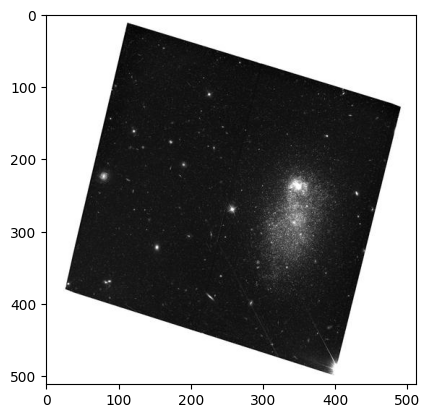

In [13]:
import sys
sys.path.append("../")

from models.dataset_utils import make_dataloader, create_input_iter

files = ['../data/observations.tfrecord']
ds = make_dataloader(files, batch_size=32, seed=42)
create_input_iter(ds)

image, caption = next(iter(ds))

import matplotlib.pyplot as plt
plt.imshow(image[0], vmin=0, vmax=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


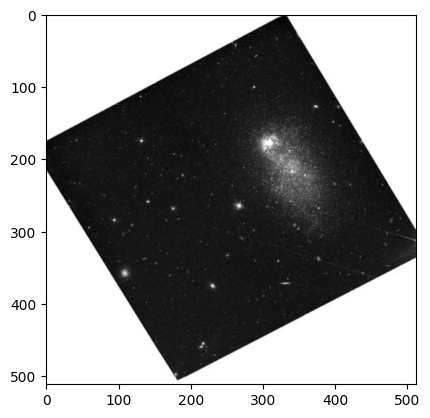

In [24]:
import cv2
import numpy as np

def rotate_and_fill(image, angle_deg):
    # Get image dimensions
    h, w = image.shape[:2]
    
    # Define the center of the image
    center = (w // 2, h // 2)
    
    # Get the rotation matrix
    rot_matrix = cv2.getRotationMatrix2D(center, angle_deg, 1.0)
    
    # Perform rotation
    rotated_image = cv2.warpAffine(image, rot_matrix, (w, h), flags=cv2.INTER_LINEAR, 
                                   borderMode=cv2.BORDER_CONSTANT, borderValue=(255,255,255))
    return rotated_image

plt.imshow(rotate_and_fill(image[0].numpy(), 45.), vmin=0, vmax=1)

In [35]:
image.shape

TensorShape([32, 512, 512, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


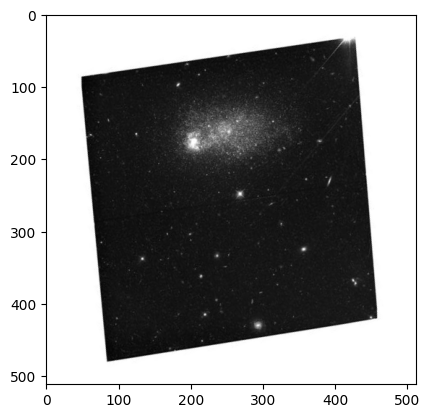

In [37]:
import tensorflow as tf
import tensorflow_addons as tfa

def rotate_batch(images, angles):
    """
    Rotates a batch of images by a batch of angles.

    :param images: A 4D tensor of shape [batch_size, height, width, channels].
    :param angles: A 1D tensor of shape [batch_size], representing the angles (in degrees) to rotate the images.
    :return: A 4D tensor of shape [batch_size, height, width, channels] representing the rotated images.
    """
    # Convert angles from degrees to radians
    angles_rad = tf.convert_to_tensor(angles) * (np.pi / 180)

    # Rotate the batch of images
    rotated_images = tfa.image.rotate(images, angles_rad, interpolation='BILINEAR', fill_mode='constant', fill_value=255.0)

    return rotated_images

# Example Usage:
batch_of_images = image  # Example with 10 color images
batch_of_angles = tf.random.uniform((32,), minval=0, maxval=360, dtype=tf.float32)  # Corresponding 10 rotation angles

rotated_images = rotate_batch(batch_of_images, batch_of_angles)
rotated_images_np = rotated_images.numpy()  # Convert to numpy array

plt.imshow(rotated_images_np[0])

In [38]:
! pip install dm-pix


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 394.6 kB/s eta 0:00:00m eta -:--:--


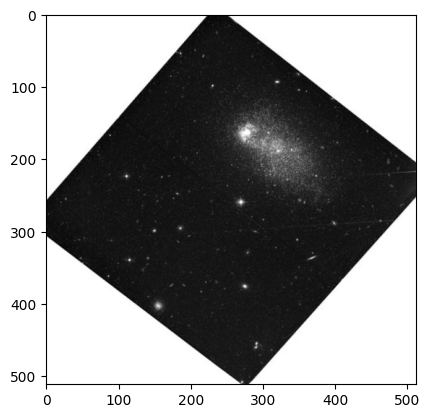

In [68]:
from dm_pix import rotate
import jax

plt.imshow(jax.vmap(rotate)(jnp.array(image), jnp.ones(32) * 20.)[0])

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

In [ ]:
caption = caption.numpy().tolist()
caption = [c.decode('utf-8') for c in caption]

tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=300,
            return_tensors="np",
        )

{'input_ids': array([[49406,  1746, 13690, ...,   537, 36128, 49407],
       [49406,  1746, 13690, ...,   537, 36128, 49407],
       [49406,  1746, 13690, ...,   537, 36128, 49407],
       ...,
       [49406, 14171,  5357, ..., 49407, 49407, 49407],
       [49406, 14171,  5357, ..., 49407, 49407, 49407],
       [49406, 14171,  5357, ..., 49407, 49407, 49407]]), 'attention_mask': array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}